# Face Generation
This is a modification of the face generation project found on udacity's Deep Learning course. The project will be to generate faces but, this time using self-normalizing units instead of batch normalization.

### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex I test the GAN on MNIST before CelebA. This should allow me to see how the model trains sooner.


In [1]:
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

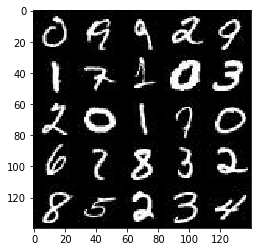

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
import pickle as pkl
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

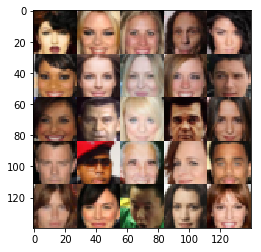

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf
import numpy as np

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


# SELU Implementation 

SELU Implementation based on the the ipynb
https://github.com/bioinf-jku/SNNs/blob/master/getSELUparameters.ipynb


In [5]:
from scipy.special import erf,erfc
from sympy import Symbol, solve, nsolve


In [6]:
from __future__ import absolute_import, division, print_function
import numbers
from tensorflow.contrib import layers
from tensorflow.python.framework import ops
from tensorflow.python.framework import tensor_shape
from tensorflow.python.framework import tensor_util
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import random_ops
from tensorflow.python.ops import array_ops
from tensorflow.python.layers import utils

In [7]:
def getSeluParameters(fixedpointMean=0,fixedpointVar=1):
    """ Finding the parameters of the SELU activation function. The function returns alpha and lambda for the desired fixed point. """
    
    import sympy
    from sympy import Symbol, solve, nsolve

    aa = Symbol('aa')
    ll = Symbol('ll')
    nu = fixedpointMean 
    tau = fixedpointVar 

    mean =  0.5*ll*(nu + np.exp(-nu**2/(2*tau))*np.sqrt(2/np.pi)*np.sqrt(tau) + \
                        nu*erf(nu/(np.sqrt(2*tau))) - aa*erfc(nu/(np.sqrt(2*tau))) + \
                        np.exp(nu+tau/2)*aa*erfc((nu+tau)/(np.sqrt(2*tau))))

    var = 0.5*ll**2*(np.exp(-nu**2/(2*tau))*np.sqrt(2/np.pi*tau)*nu + (nu**2+tau)* \
                          (1+erf(nu/(np.sqrt(2*tau)))) + aa**2 *erfc(nu/(np.sqrt(2*tau))) \
                          - aa**2 * 2 *np.exp(nu+tau/2)*erfc((nu+tau)/(np.sqrt(2*tau)))+ \
                          aa**2*np.exp(2*(nu+tau))*erfc((nu+2*tau)/(np.sqrt(2*tau))) ) - mean**2

    eq1 = mean - nu
    eq2 = var - tau

    res = nsolve( (eq2, eq1), (aa,ll), (1.67,1.05))
    return float(res[0]),float(res[1])

In [8]:
### To recover the parameters of the SELU with mean zero and unit variance
getSeluParameters(0,1)
## To obtain new parameters for mean zero and variance 2
myFixedPointMean = 0
myFixedPointVar = 1.0
myAlpha, myLambda = getSeluParameters(myFixedPointMean,myFixedPointVar)
getSeluParameters(myFixedPointMean,myFixedPointVar)

(1.6732632423543778, 1.0507009873554802)

In [9]:
def selu(x):
    with ops.name_scope('elu') as scope:
        alpha = myAlpha
        scale = myLambda
        return scale*tf.where(x>=0.0, x, alpha*tf.nn.elu(x))

def dropout_selu(x, rate, alpha= -myAlpha*myLambda, fixedPointMean=myFixedPointMean, fixedPointVar=myFixedPointVar, 
                 noise_shape=None, seed=None, name=None, training=False):
    """Dropout to a value with rescaling."""

    def dropout_selu_impl(x, rate, alpha, noise_shape, seed, name):
        keep_prob = 1.0 - rate
        x = ops.convert_to_tensor(x, name="x")
        if isinstance(keep_prob, numbers.Real) and not 0 < keep_prob <= 1:
            raise ValueError("keep_prob must be a scalar tensor or a float in the "
                                             "range (0, 1], got %g" % keep_prob)
        keep_prob = ops.convert_to_tensor(keep_prob, dtype=x.dtype, name="keep_prob")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        alpha = ops.convert_to_tensor(alpha, dtype=x.dtype, name="alpha")
        keep_prob.get_shape().assert_is_compatible_with(tensor_shape.scalar())

        if tensor_util.constant_value(keep_prob) == 1:
            return x

        noise_shape = noise_shape if noise_shape is not None else array_ops.shape(x)
        random_tensor = keep_prob
        random_tensor += random_ops.random_uniform(noise_shape, seed=seed, dtype=x.dtype)
        binary_tensor = math_ops.floor(random_tensor)
        ret = x * binary_tensor + alpha * (1-binary_tensor)


        a = tf.sqrt(fixedPointVar / (keep_prob *((1-keep_prob) * tf.pow(alpha-fixedPointMean,2) + fixedPointVar)))
        
        b = fixedPointMean - a * (keep_prob * fixedPointMean + (1 - keep_prob) * alpha)
        ret = a * ret + b
        ret.set_shape(x.get_shape())
        return ret

    with ops.name_scope(name, "dropout", [x]) as name:
        return utils.smart_cond(training,
            lambda: dropout_selu_impl(x, rate, alpha, noise_shape, seed, name),
            lambda: array_ops.identity(x))

### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [10]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_images = tf.placeholder(dtype=tf.float32, 
                                 shape=(None, image_width, image_height, image_channels),
                                 name='real_images')
    
    z_input = tf.placeholder(dtype=tf.float32,
                             shape=(None, z_dim),
                             name='z_input')
    
    learning_rate = tf.placeholder(dtype=tf.float32, name='learning_rate')
    
    drop_prob = tf.placeholder(dtype=tf.float32, name='drop_prob')

    return real_images, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [11]:
def discriminator(images, reuse=False, alpha=0.1):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    drop_rate=0.1
    keep_prob=1-drop_rate
    
    with tf.variable_scope('discriminator', reuse=reuse):
        # Starts 28x28x3
        x1 = tf.layers.conv2d(images, filters=64,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME',
                             )
        # Now 14x14x64
        a1 = selu(x1)
        d1 = dropout_selu(a1,rate=keep_prob)
        
        x2 = tf.layers.conv2d(d1, filters=128,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME')
        # Now 7x7x128
        a2 = selu(x2)
        d2 = dropout_selu(a2, rate=keep_prob)
        
        x3 = tf.layers.conv2d(d2, filters=256,
                              kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                              kernel_size=(5,5),
                              strides=(2,2),
                              padding='SAME')
        # Now 4x4x256
        a3 = selu(x3)
        
        d3 = dropout_selu(a3, rate=keep_prob)
        
        x4 = tf.reshape(d3, shape=(-1, 4*4*256))
        # Now size = [batch_size, 4096 = 4*4*256]
        
        logits = tf.layers.dense(inputs=x4, units=1)
        
        output = tf.nn.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [12]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha =0.1
    with tf.variable_scope('generator', reuse= not is_train):
        fc1 = tf.layers.dense(z, units=3*3*512)
        x1 = tf.reshape(fc1, shape=(-1,3,3,512))
        # Shape is 4x4x512
        cn1 = tf.layers.conv2d_transpose(x1,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=256,
                                         kernel_size=(5,5),
                                         strides=(1,1),
                                         padding='VALID')
        #print(cn1.shape)
        # Shape should be 7x7x256
        #print(cn1.shape)
        a1 = selu(cn1)
        
        cn2 = tf.layers.conv2d_transpose(a1,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=128,
                                         kernel_size=(5,5),
                                         strides=(2,2),
                                         padding='SAME')
        #print(cn2.shape)
        #shape 14x14x128
        #print(cn2.shape)
        a2 = selu(cn2)
        
        cn3 = tf.layers.conv2d_transpose(a2,
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d(),
                                         filters=out_channel_dim,
                                         kernel_size=(5,5),
                                         strides=(2,2),
                                         padding='SAME')
        #shape 28x28xout_channel_dim
        #print(cn3.shape)
        output = tf.tanh(cn3)
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [13]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    d_real_outputs, d_real_logits = discriminator(input_real, reuse=False)
    g_outputs = generator(input_z, out_channel_dim, is_train=True)
    d_fake_outputs, d_fake_logits = discriminator(g_outputs, reuse=True)
    
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_real_logits,
        labels=tf.ones_like(d_real_logits)*0.9))
    
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits,
        labels=tf.zeros_like(d_fake_logits)))
    
    d_loss = d_loss_real + d_loss_fake
    
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
        logits=d_fake_logits,
        labels=tf.ones_like(d_fake_logits)))
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [14]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_optimizer = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss,var_list=g_vars)
    
    return d_optimizer, g_optimizer


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [15]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()
    return images_grid

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    real_images, z_inputs, lr = model_inputs(data_shape[1],data_shape[2],data_shape[3],z_dim)
    #the numbers for model inputs are determined by the data
    if data_image_mode is "RGB":
        out_channel_dim = 3
    else:
        out_channel_dim = 1
        
    d_loss, g_loss = model_loss(real_images, z_inputs, out_channel_dim)
    
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))

    samples, losses = [], []
    steps = 0    

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                z_data = np.random.uniform(low=-1,
                                           high=1,
                                           size=(batch_size, z_dim))
                
                _ =sess.run(d_opt,feed_dict={real_images: batch_images,
                                             z_inputs: z_data,
                                             lr: learning_rate})
                _ =sess.run(g_opt,feed_dict={real_images: batch_images,
                                             z_inputs: z_data,
                                             lr: learning_rate})
                if steps%25==0:
                    train_loss_d = d_loss.eval({z_inputs: z_data, real_images: 2*batch_images})
                    train_loss_g = g_loss.eval({z_inputs: z_data})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                
                if steps%100==0:
                    samples.append(show_generator_output(sess, 25, z_inputs, out_channel_dim, data_image_mode))
                    saver.save(sess, './checkpoints/generator.ckpt',global_step=steps)
                    
    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples            

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9238... Generator Loss: 1.3929
Epoch 1/2... Discriminator Loss: 1.0465... Generator Loss: 1.8880
Epoch 1/2... Discriminator Loss: 1.7512... Generator Loss: 0.6349
Epoch 1/2... Discriminator Loss: 1.1021... Generator Loss: 0.9447


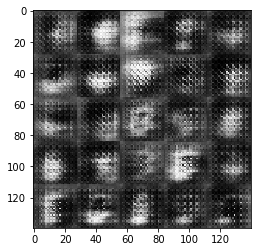

Epoch 1/2... Discriminator Loss: 2.0889... Generator Loss: 0.6630
Epoch 1/2... Discriminator Loss: 1.4623... Generator Loss: 0.7116
Epoch 1/2... Discriminator Loss: 1.6692... Generator Loss: 0.8819
Epoch 1/2... Discriminator Loss: 1.5732... Generator Loss: 0.8155


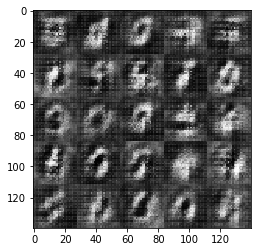

Epoch 1/2... Discriminator Loss: 1.9089... Generator Loss: 0.7898
Epoch 1/2... Discriminator Loss: 2.3838... Generator Loss: 0.9336
Epoch 1/2... Discriminator Loss: 1.6358... Generator Loss: 0.5409
Epoch 1/2... Discriminator Loss: 1.8139... Generator Loss: 0.6644


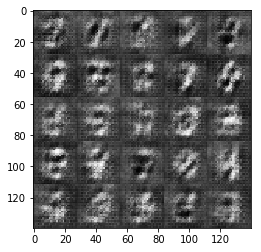

Epoch 1/2... Discriminator Loss: 1.7261... Generator Loss: 0.7572
Epoch 1/2... Discriminator Loss: 1.4600... Generator Loss: 0.6674
Epoch 1/2... Discriminator Loss: 1.5645... Generator Loss: 0.9079
Epoch 1/2... Discriminator Loss: 1.8373... Generator Loss: 0.8193


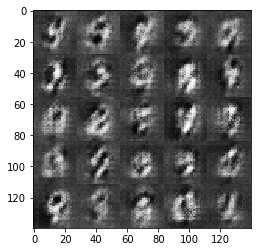

Epoch 1/2... Discriminator Loss: 1.4216... Generator Loss: 0.8074
Epoch 1/2... Discriminator Loss: 1.6277... Generator Loss: 0.9328
Epoch 1/2... Discriminator Loss: 1.4928... Generator Loss: 0.6385
Epoch 1/2... Discriminator Loss: 1.6404... Generator Loss: 1.1280


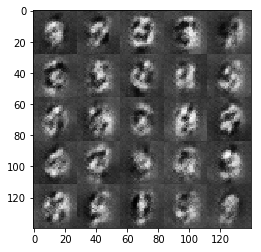

Epoch 1/2... Discriminator Loss: 1.3726... Generator Loss: 0.9039
Epoch 1/2... Discriminator Loss: 1.4513... Generator Loss: 0.5487
Epoch 1/2... Discriminator Loss: 1.3249... Generator Loss: 0.6441
Epoch 1/2... Discriminator Loss: 1.4025... Generator Loss: 0.6035


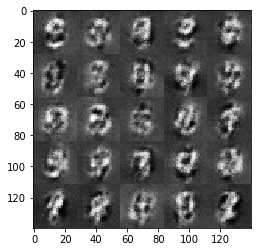

Epoch 1/2... Discriminator Loss: 1.7946... Generator Loss: 1.0039
Epoch 1/2... Discriminator Loss: 1.5016... Generator Loss: 0.6598
Epoch 1/2... Discriminator Loss: 1.4178... Generator Loss: 0.9056
Epoch 1/2... Discriminator Loss: 1.2580... Generator Loss: 1.0006


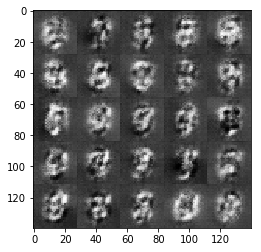

Epoch 1/2... Discriminator Loss: 1.4627... Generator Loss: 0.5948
Epoch 1/2... Discriminator Loss: 1.4753... Generator Loss: 1.0189
Epoch 1/2... Discriminator Loss: 1.2107... Generator Loss: 0.7996
Epoch 1/2... Discriminator Loss: 1.3280... Generator Loss: 0.6939


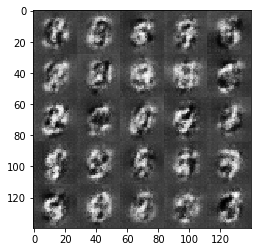

Epoch 1/2... Discriminator Loss: 1.8627... Generator Loss: 1.3007
Epoch 1/2... Discriminator Loss: 1.3679... Generator Loss: 0.4840
Epoch 1/2... Discriminator Loss: 1.2629... Generator Loss: 0.6153
Epoch 1/2... Discriminator Loss: 1.3955... Generator Loss: 0.7548


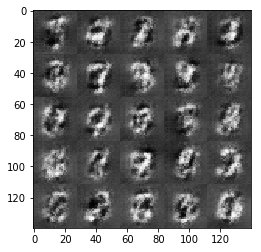

Epoch 1/2... Discriminator Loss: 2.4981... Generator Loss: 1.9172
Epoch 1/2... Discriminator Loss: 1.4229... Generator Loss: 1.0394
Epoch 1/2... Discriminator Loss: 1.8072... Generator Loss: 1.3729
Epoch 1/2... Discriminator Loss: 2.1567... Generator Loss: 1.5166


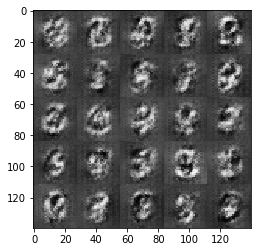

Epoch 1/2... Discriminator Loss: 1.3073... Generator Loss: 0.5817
Epoch 1/2... Discriminator Loss: 1.2851... Generator Loss: 0.9172
Epoch 1/2... Discriminator Loss: 1.6743... Generator Loss: 1.0701
Epoch 1/2... Discriminator Loss: 2.0116... Generator Loss: 1.0315


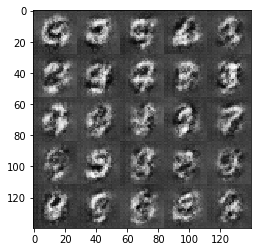

Epoch 1/2... Discriminator Loss: 3.5428... Generator Loss: 2.4735
Epoch 1/2... Discriminator Loss: 1.6693... Generator Loss: 1.1157
Epoch 1/2... Discriminator Loss: 1.8132... Generator Loss: 1.4734
Epoch 1/2... Discriminator Loss: 1.4822... Generator Loss: 0.7797


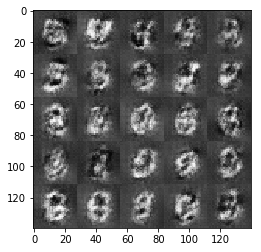

Epoch 1/2... Discriminator Loss: 1.5099... Generator Loss: 0.8887
Epoch 1/2... Discriminator Loss: 1.7158... Generator Loss: 0.9175
Epoch 1/2... Discriminator Loss: 1.7177... Generator Loss: 0.6989
Epoch 1/2... Discriminator Loss: 3.0347... Generator Loss: 1.4111


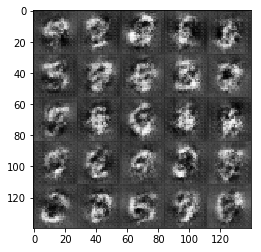

Epoch 1/2... Discriminator Loss: 1.4035... Generator Loss: 0.9751
Epoch 1/2... Discriminator Loss: 2.0635... Generator Loss: 1.5241
Epoch 1/2... Discriminator Loss: 2.1055... Generator Loss: 1.2691
Epoch 1/2... Discriminator Loss: 1.5255... Generator Loss: 0.5591


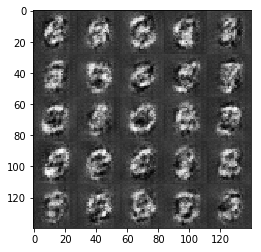

Epoch 1/2... Discriminator Loss: 1.4223... Generator Loss: 0.6820
Epoch 1/2... Discriminator Loss: 1.9126... Generator Loss: 1.1867
Epoch 1/2... Discriminator Loss: 3.0786... Generator Loss: 1.8877
Epoch 1/2... Discriminator Loss: 2.0854... Generator Loss: 1.4991


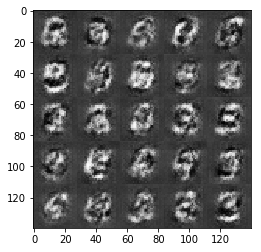

Epoch 1/2... Discriminator Loss: 1.8648... Generator Loss: 1.3923
Epoch 1/2... Discriminator Loss: 1.2793... Generator Loss: 0.5916
Epoch 1/2... Discriminator Loss: 1.9012... Generator Loss: 1.4992
Epoch 1/2... Discriminator Loss: 1.4248... Generator Loss: 1.1778


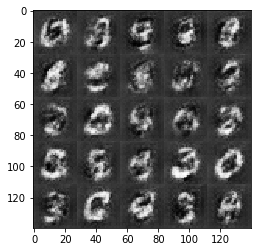

Epoch 1/2... Discriminator Loss: 3.5672... Generator Loss: 2.7359
Epoch 1/2... Discriminator Loss: 2.1071... Generator Loss: 1.8849
Epoch 1/2... Discriminator Loss: 1.4457... Generator Loss: 0.8942
Epoch 1/2... Discriminator Loss: 2.5133... Generator Loss: 1.6674


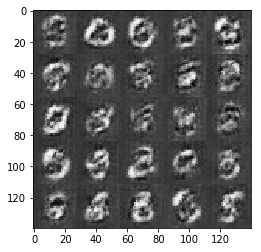

Epoch 1/2... Discriminator Loss: 1.6943... Generator Loss: 1.2314
Epoch 1/2... Discriminator Loss: 1.4830... Generator Loss: 0.5582
Epoch 1/2... Discriminator Loss: 1.7900... Generator Loss: 0.9237
Epoch 1/2... Discriminator Loss: 2.0264... Generator Loss: 0.9554


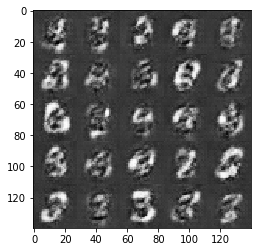

Epoch 1/2... Discriminator Loss: 2.2184... Generator Loss: 1.2637
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.9769
Epoch 1/2... Discriminator Loss: 1.4923... Generator Loss: 0.8768
Epoch 2/2... Discriminator Loss: 1.6037... Generator Loss: 1.1619


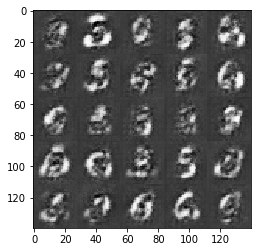

Epoch 2/2... Discriminator Loss: 2.9388... Generator Loss: 1.9486
Epoch 2/2... Discriminator Loss: 2.0245... Generator Loss: 1.4997
Epoch 2/2... Discriminator Loss: 2.0605... Generator Loss: 0.9750
Epoch 2/2... Discriminator Loss: 1.7698... Generator Loss: 0.7806


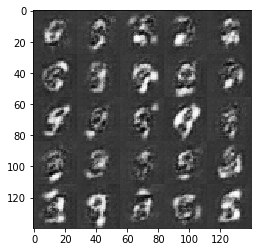

Epoch 2/2... Discriminator Loss: 1.9171... Generator Loss: 0.8502
Epoch 2/2... Discriminator Loss: 1.4499... Generator Loss: 0.7752
Epoch 2/2... Discriminator Loss: 3.0898... Generator Loss: 2.4893
Epoch 2/2... Discriminator Loss: 1.8679... Generator Loss: 1.6240


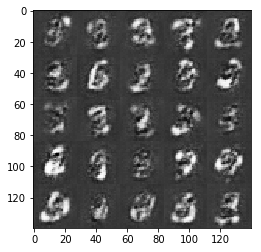

Epoch 2/2... Discriminator Loss: 1.7502... Generator Loss: 1.1192
Epoch 2/2... Discriminator Loss: 3.5293... Generator Loss: 2.0758
Epoch 2/2... Discriminator Loss: 2.1541... Generator Loss: 1.7341
Epoch 2/2... Discriminator Loss: 1.4884... Generator Loss: 0.8746


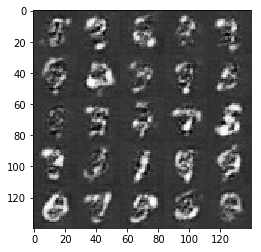

Epoch 2/2... Discriminator Loss: 1.4253... Generator Loss: 0.6284
Epoch 2/2... Discriminator Loss: 2.2552... Generator Loss: 1.4031
Epoch 2/2... Discriminator Loss: 1.6908... Generator Loss: 0.9485
Epoch 2/2... Discriminator Loss: 2.6381... Generator Loss: 1.4288


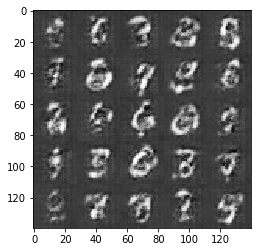

Epoch 2/2... Discriminator Loss: 2.2515... Generator Loss: 1.5980
Epoch 2/2... Discriminator Loss: 3.3895... Generator Loss: 2.3134
Epoch 2/2... Discriminator Loss: 2.6056... Generator Loss: 2.0327
Epoch 2/2... Discriminator Loss: 3.4030... Generator Loss: 2.5509


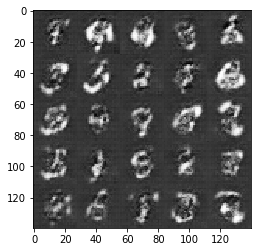

Epoch 2/2... Discriminator Loss: 2.6250... Generator Loss: 1.7304
Epoch 2/2... Discriminator Loss: 3.0311... Generator Loss: 2.0386
Epoch 2/2... Discriminator Loss: 2.0240... Generator Loss: 0.9907
Epoch 2/2... Discriminator Loss: 4.5365... Generator Loss: 3.0792


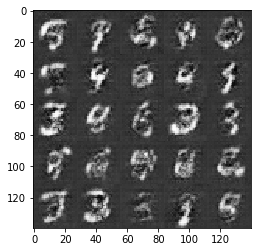

Epoch 2/2... Discriminator Loss: 1.7777... Generator Loss: 0.8897
Epoch 2/2... Discriminator Loss: 3.0440... Generator Loss: 2.2690
Epoch 2/2... Discriminator Loss: 2.4464... Generator Loss: 1.9350
Epoch 2/2... Discriminator Loss: 4.2276... Generator Loss: 2.6439


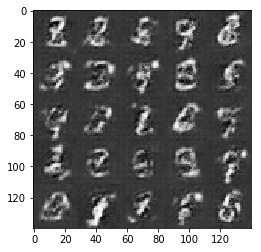

Epoch 2/2... Discriminator Loss: 2.3423... Generator Loss: 1.2869
Epoch 2/2... Discriminator Loss: 4.6518... Generator Loss: 2.7962
Epoch 2/2... Discriminator Loss: 3.7753... Generator Loss: 2.7683
Epoch 2/2... Discriminator Loss: 3.6207... Generator Loss: 1.4454


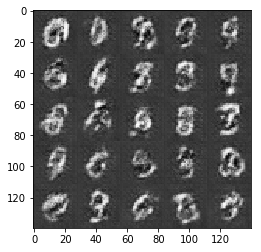

Epoch 2/2... Discriminator Loss: 2.0325... Generator Loss: 1.0957
Epoch 2/2... Discriminator Loss: 2.4532... Generator Loss: 1.5925
Epoch 2/2... Discriminator Loss: 2.7813... Generator Loss: 1.5054
Epoch 2/2... Discriminator Loss: 3.6955... Generator Loss: 1.8282


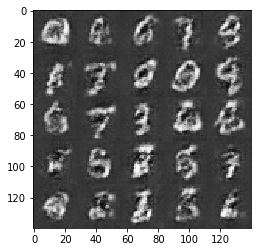

Epoch 2/2... Discriminator Loss: 2.2203... Generator Loss: 1.1845
Epoch 2/2... Discriminator Loss: 4.1230... Generator Loss: 1.5237
Epoch 2/2... Discriminator Loss: 3.9566... Generator Loss: 2.0665
Epoch 2/2... Discriminator Loss: 2.0141... Generator Loss: 0.8435


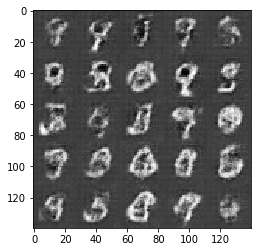

Epoch 2/2... Discriminator Loss: 4.2344... Generator Loss: 2.6157
Epoch 2/2... Discriminator Loss: 3.8900... Generator Loss: 1.5021
Epoch 2/2... Discriminator Loss: 3.9168... Generator Loss: 1.9852
Epoch 2/2... Discriminator Loss: 3.9040... Generator Loss: 1.4582


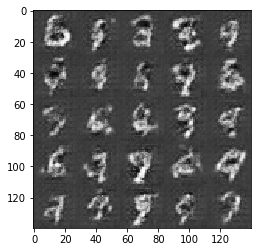

Epoch 2/2... Discriminator Loss: 2.8544... Generator Loss: 1.3416
Epoch 2/2... Discriminator Loss: 4.3316... Generator Loss: 2.2313
Epoch 2/2... Discriminator Loss: 4.7337... Generator Loss: 2.1246
Epoch 2/2... Discriminator Loss: 3.9888... Generator Loss: 1.4656


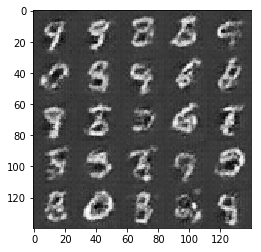

Epoch 2/2... Discriminator Loss: 4.0323... Generator Loss: 1.4880
Epoch 2/2... Discriminator Loss: 5.3572... Generator Loss: 2.2856
Epoch 2/2... Discriminator Loss: 4.8322... Generator Loss: 2.5818
Epoch 2/2... Discriminator Loss: 2.7252... Generator Loss: 0.8575


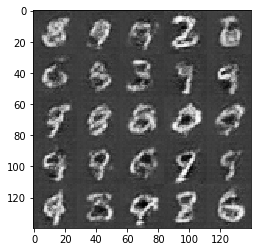

Epoch 2/2... Discriminator Loss: 4.2346... Generator Loss: 1.7093
Epoch 2/2... Discriminator Loss: 3.6688... Generator Loss: 1.0396
Epoch 2/2... Discriminator Loss: 2.9110... Generator Loss: 1.6482
Epoch 2/2... Discriminator Loss: 5.8194... Generator Loss: 2.9959


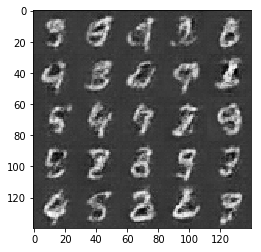

Epoch 2/2... Discriminator Loss: 4.6159... Generator Loss: 2.2279
Epoch 2/2... Discriminator Loss: 5.2734... Generator Loss: 2.8007
Epoch 2/2... Discriminator Loss: 4.9369... Generator Loss: 2.7336
Epoch 2/2... Discriminator Loss: 5.0491... Generator Loss: 2.6508


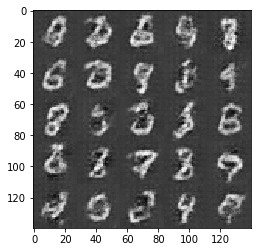

Epoch 2/2... Discriminator Loss: 5.4155... Generator Loss: 2.8552
Epoch 2/2... Discriminator Loss: 2.7303... Generator Loss: 0.4553
Epoch 2/2... Discriminator Loss: 4.1102... Generator Loss: 1.5298
Epoch 2/2... Discriminator Loss: 5.0288... Generator Loss: 2.0174


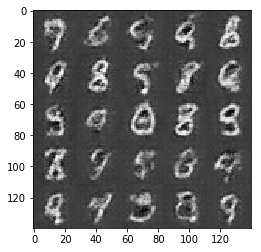

Epoch 2/2... Discriminator Loss: 5.7761... Generator Loss: 3.0426
Epoch 2/2... Discriminator Loss: 2.9695... Generator Loss: 1.1470
Epoch 2/2... Discriminator Loss: 4.8097... Generator Loss: 2.0585
Epoch 2/2... Discriminator Loss: 3.0897... Generator Loss: 0.7227


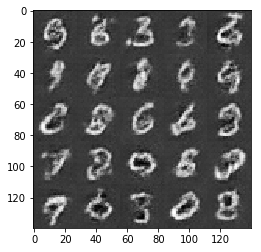

Epoch 2/2... Discriminator Loss: 2.8321... Generator Loss: 0.8492
Epoch 2/2... Discriminator Loss: 4.8806... Generator Loss: 1.6133
Epoch 2/2... Discriminator Loss: 4.3430... Generator Loss: 1.2900
Epoch 2/2... Discriminator Loss: 4.0709... Generator Loss: 0.7469


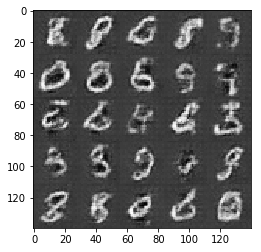

Epoch 2/2... Discriminator Loss: 3.2574... Generator Loss: 1.4864
Epoch 2/2... Discriminator Loss: 4.2603... Generator Loss: 1.2364


In [17]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0611... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 1.2034
Epoch 1/1... Discriminator Loss: 1.1129... Generator Loss: 1.0950
Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.6369


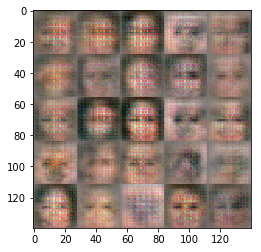

Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.6487
Epoch 1/1... Discriminator Loss: 1.5189... Generator Loss: 0.7084
Epoch 1/1... Discriminator Loss: 1.9486... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.7533... Generator Loss: 0.5585


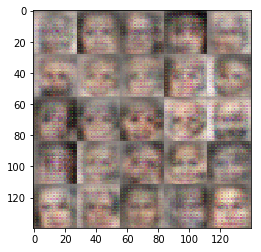

Epoch 1/1... Discriminator Loss: 1.6381... Generator Loss: 0.6095
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.6834


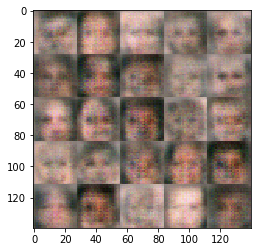

Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.5488... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.7406
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7306


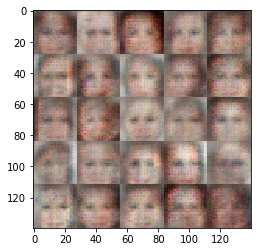

Epoch 1/1... Discriminator Loss: 1.5848... Generator Loss: 0.6935
Epoch 1/1... Discriminator Loss: 1.5031... Generator Loss: 0.7146
Epoch 1/1... Discriminator Loss: 1.4644... Generator Loss: 0.7732
Epoch 1/1... Discriminator Loss: 1.3490... Generator Loss: 0.7101


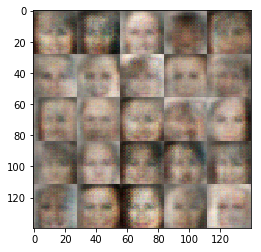

Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.7066
Epoch 1/1... Discriminator Loss: 1.4202... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.3945... Generator Loss: 0.7574
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7342


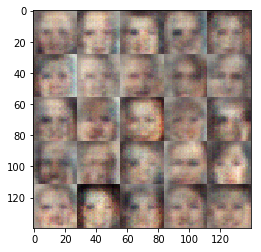

Epoch 1/1... Discriminator Loss: 1.4634... Generator Loss: 0.7972
Epoch 1/1... Discriminator Loss: 1.3087... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.3523... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.4944... Generator Loss: 0.7961


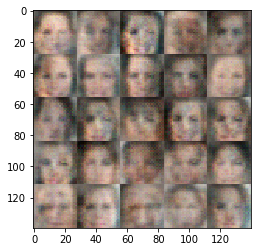

Epoch 1/1... Discriminator Loss: 1.4497... Generator Loss: 0.8773
Epoch 1/1... Discriminator Loss: 1.3591... Generator Loss: 0.7623
Epoch 1/1... Discriminator Loss: 1.3294... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7940


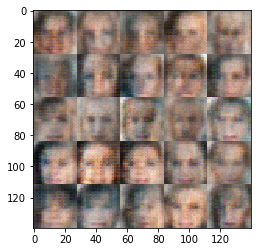

Epoch 1/1... Discriminator Loss: 1.5285... Generator Loss: 0.7678
Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.5337... Generator Loss: 0.6872
Epoch 1/1... Discriminator Loss: 1.5423... Generator Loss: 0.8241


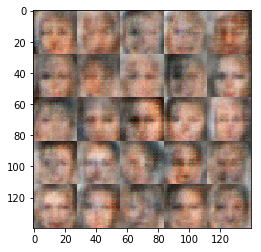

Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.6716
Epoch 1/1... Discriminator Loss: 1.5279... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6973
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.7795


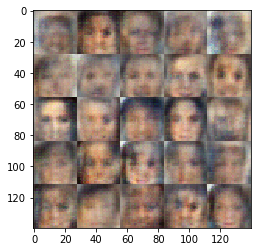

Epoch 1/1... Discriminator Loss: 1.3989... Generator Loss: 0.7826
Epoch 1/1... Discriminator Loss: 1.5257... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.7864
Epoch 1/1... Discriminator Loss: 1.4112... Generator Loss: 0.7801


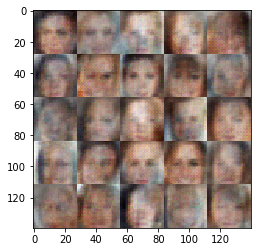

Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.7870
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.4761... Generator Loss: 0.7514


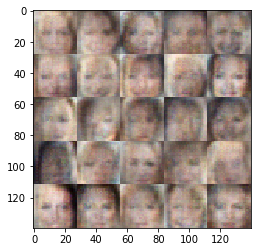

Epoch 1/1... Discriminator Loss: 1.5458... Generator Loss: 0.8109
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.6441... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.4758... Generator Loss: 0.8688


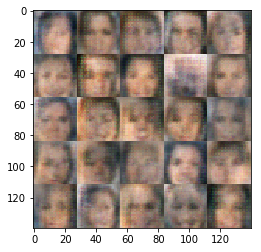

Epoch 1/1... Discriminator Loss: 1.5320... Generator Loss: 0.8087
Epoch 1/1... Discriminator Loss: 1.3542... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.8026
Epoch 1/1... Discriminator Loss: 1.7643... Generator Loss: 0.8438


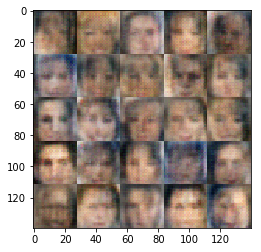

Epoch 1/1... Discriminator Loss: 1.7303... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.3553... Generator Loss: 0.9681
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.8365
Epoch 1/1... Discriminator Loss: 1.6403... Generator Loss: 0.8136


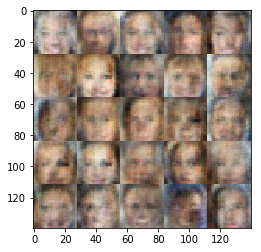

Epoch 1/1... Discriminator Loss: 1.3847... Generator Loss: 0.8593
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.7544
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7969
Epoch 1/1... Discriminator Loss: 1.5153... Generator Loss: 0.7732


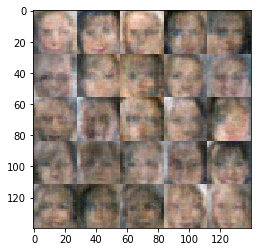

Epoch 1/1... Discriminator Loss: 1.6000... Generator Loss: 0.7671
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.6209... Generator Loss: 0.7475
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.8124


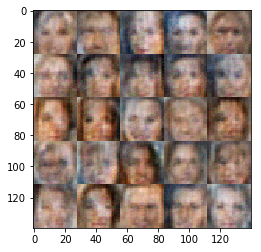

Epoch 1/1... Discriminator Loss: 1.5126... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.8709
Epoch 1/1... Discriminator Loss: 1.5375... Generator Loss: 0.8073
Epoch 1/1... Discriminator Loss: 1.5436... Generator Loss: 0.7739


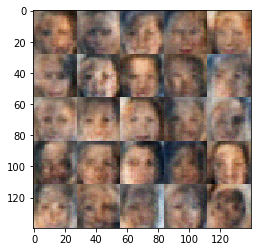

Epoch 1/1... Discriminator Loss: 1.5053... Generator Loss: 0.7912
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7586
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.3813... Generator Loss: 0.7900


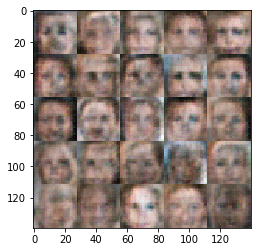

Epoch 1/1... Discriminator Loss: 1.6017... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.4953... Generator Loss: 0.7699
Epoch 1/1... Discriminator Loss: 1.6819... Generator Loss: 0.7885
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.7410


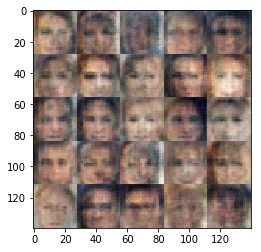

Epoch 1/1... Discriminator Loss: 1.5135... Generator Loss: 0.8529
Epoch 1/1... Discriminator Loss: 1.7036... Generator Loss: 0.8003
Epoch 1/1... Discriminator Loss: 1.4864... Generator Loss: 0.8569
Epoch 1/1... Discriminator Loss: 1.5170... Generator Loss: 0.8286


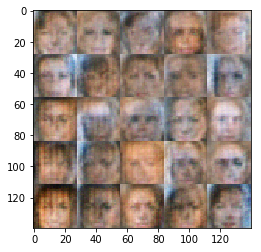

Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.7530
Epoch 1/1... Discriminator Loss: 1.6570... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.6190... Generator Loss: 0.7595
Epoch 1/1... Discriminator Loss: 1.6351... Generator Loss: 0.8125


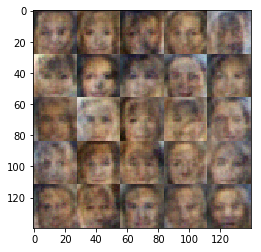

Epoch 1/1... Discriminator Loss: 1.4588... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.7846
Epoch 1/1... Discriminator Loss: 1.4429... Generator Loss: 0.7500


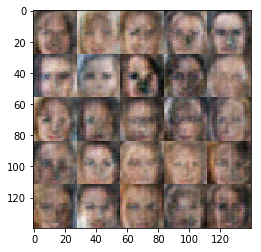

Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8137
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.6194... Generator Loss: 0.7332
Epoch 1/1... Discriminator Loss: 1.6359... Generator Loss: 0.7570


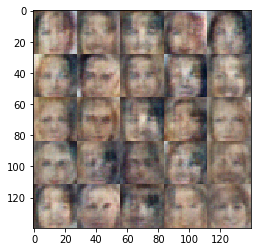

Epoch 1/1... Discriminator Loss: 1.5805... Generator Loss: 0.7603
Epoch 1/1... Discriminator Loss: 1.5569... Generator Loss: 0.8402
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.8456
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.8310


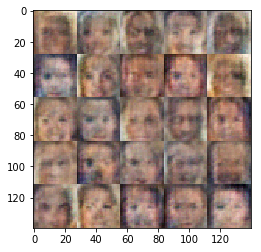

Epoch 1/1... Discriminator Loss: 1.5539... Generator Loss: 0.7471
Epoch 1/1... Discriminator Loss: 1.3892... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.5883... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.5475... Generator Loss: 0.7236


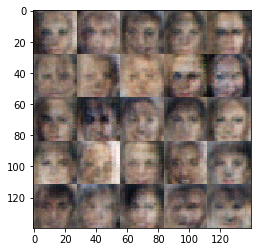

Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.4787... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.8177
Epoch 1/1... Discriminator Loss: 1.4478... Generator Loss: 0.7932


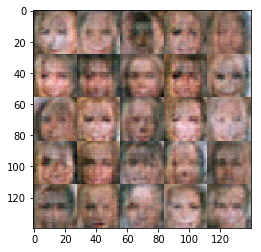

Epoch 1/1... Discriminator Loss: 1.4723... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.5665... Generator Loss: 0.7829
Epoch 1/1... Discriminator Loss: 1.4378... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.4645... Generator Loss: 0.8362


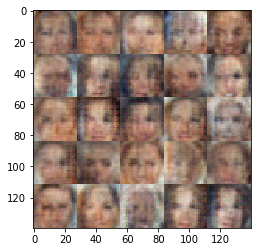

Epoch 1/1... Discriminator Loss: 1.5059... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.3916... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.5511... Generator Loss: 0.7910
Epoch 1/1... Discriminator Loss: 1.4784... Generator Loss: 0.8364


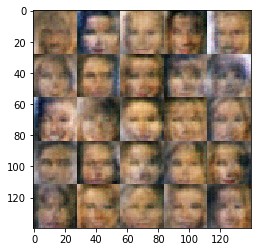

Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.5937... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 1.3732... Generator Loss: 0.8162
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.7267


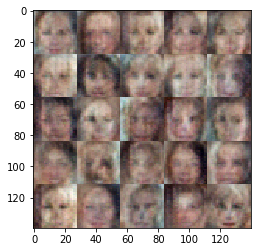

Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.3650... Generator Loss: 0.8654
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.8634


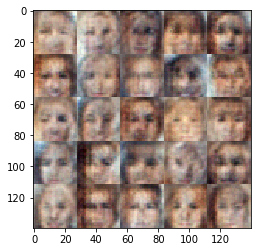

Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.7185
Epoch 1/1... Discriminator Loss: 1.4576... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.3700... Generator Loss: 0.7707
Epoch 1/1... Discriminator Loss: 1.5026... Generator Loss: 0.7239


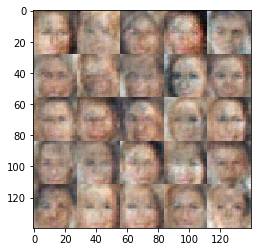

Epoch 1/1... Discriminator Loss: 1.4523... Generator Loss: 0.8254
Epoch 1/1... Discriminator Loss: 1.4199... Generator Loss: 0.7920
Epoch 1/1... Discriminator Loss: 1.5586... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.5253... Generator Loss: 0.7813


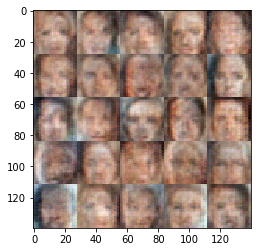

Epoch 1/1... Discriminator Loss: 1.2789... Generator Loss: 0.7257
Epoch 1/1... Discriminator Loss: 1.3134... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.7831
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.8502


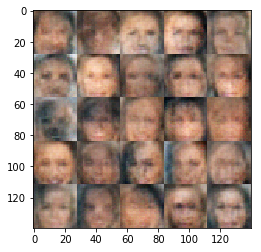

Epoch 1/1... Discriminator Loss: 1.4664... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.3683... Generator Loss: 0.7835
Epoch 1/1... Discriminator Loss: 1.4578... Generator Loss: 0.8463
Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.7770


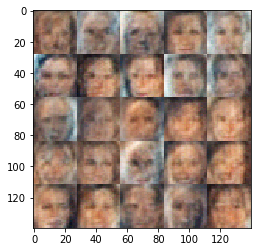

Epoch 1/1... Discriminator Loss: 1.4827... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.5386... Generator Loss: 0.7848
Epoch 1/1... Discriminator Loss: 1.4539... Generator Loss: 0.7783
Epoch 1/1... Discriminator Loss: 1.3419... Generator Loss: 0.7807


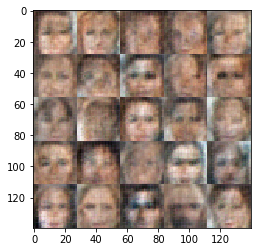

Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7554
Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.7384
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.7896
Epoch 1/1... Discriminator Loss: 1.3616... Generator Loss: 0.8026


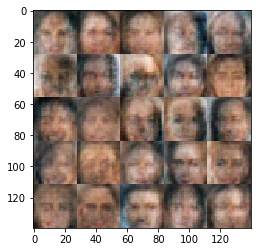

Epoch 1/1... Discriminator Loss: 1.3860... Generator Loss: 0.8146
Epoch 1/1... Discriminator Loss: 1.3722... Generator Loss: 0.7824
Epoch 1/1... Discriminator Loss: 1.4480... Generator Loss: 0.8316
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7679


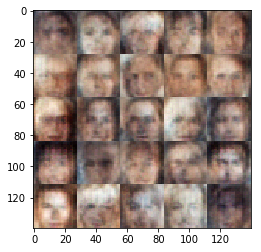

Epoch 1/1... Discriminator Loss: 1.4657... Generator Loss: 0.7457
Epoch 1/1... Discriminator Loss: 1.4756... Generator Loss: 0.8416
Epoch 1/1... Discriminator Loss: 1.4832... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.3747... Generator Loss: 0.8444


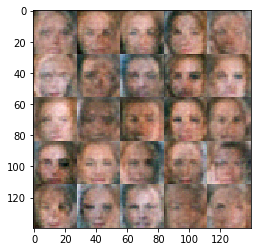

Epoch 1/1... Discriminator Loss: 1.4456... Generator Loss: 0.7549
Epoch 1/1... Discriminator Loss: 1.3772... Generator Loss: 0.7874
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.8163
Epoch 1/1... Discriminator Loss: 1.3435... Generator Loss: 0.7761


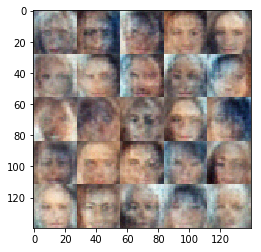

Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.8260
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.3577... Generator Loss: 0.8032
Epoch 1/1... Discriminator Loss: 1.4105... Generator Loss: 0.7884


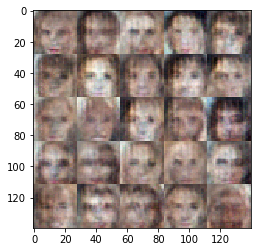

Epoch 1/1... Discriminator Loss: 1.4377... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.8169
Epoch 1/1... Discriminator Loss: 1.5462... Generator Loss: 0.7940
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7528


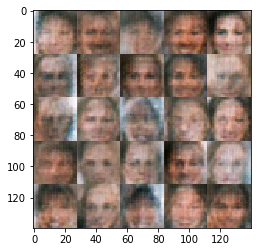

Epoch 1/1... Discriminator Loss: 1.4317... Generator Loss: 0.8064
Epoch 1/1... Discriminator Loss: 1.4886... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.3666... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.4650... Generator Loss: 0.7557


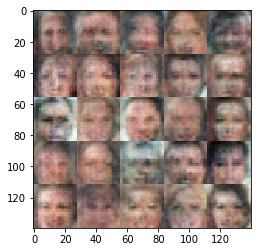

Epoch 1/1... Discriminator Loss: 1.4882... Generator Loss: 0.8049
Epoch 1/1... Discriminator Loss: 1.4744... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.8152
Epoch 1/1... Discriminator Loss: 1.4314... Generator Loss: 0.7508


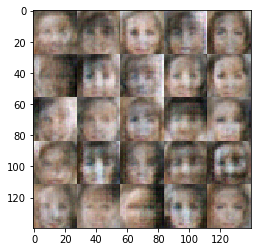

Epoch 1/1... Discriminator Loss: 1.5176... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.8127
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.8116
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.8166


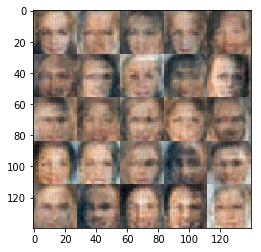

Epoch 1/1... Discriminator Loss: 1.2846... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4630... Generator Loss: 0.8378
Epoch 1/1... Discriminator Loss: 1.3173... Generator Loss: 0.7672
Epoch 1/1... Discriminator Loss: 1.5200... Generator Loss: 0.7443


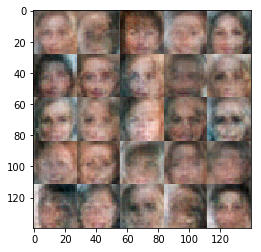

Epoch 1/1... Discriminator Loss: 1.4312... Generator Loss: 0.7871
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.3651... Generator Loss: 0.8112
Epoch 1/1... Discriminator Loss: 1.3200... Generator Loss: 0.7593


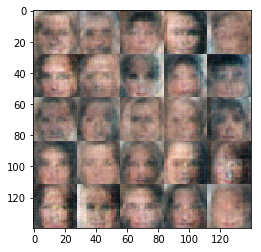

Epoch 1/1... Discriminator Loss: 1.3067... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.3308... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.7785


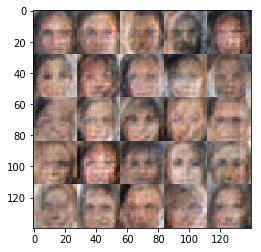

Epoch 1/1... Discriminator Loss: 1.4151... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7976
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.8190
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.7965


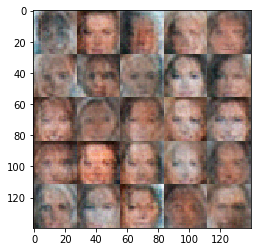

Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.8399
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.7877
Epoch 1/1... Discriminator Loss: 1.4246... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.4382... Generator Loss: 0.7876


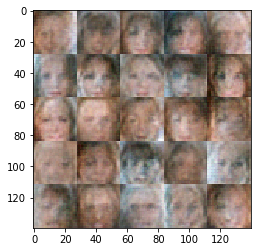

Epoch 1/1... Discriminator Loss: 1.4961... Generator Loss: 0.7811
Epoch 1/1... Discriminator Loss: 1.4516... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.8013


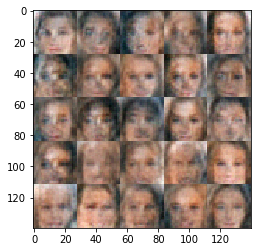

Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.7430
Epoch 1/1... Discriminator Loss: 1.4285... Generator Loss: 0.8187


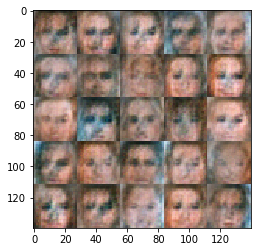

Epoch 1/1... Discriminator Loss: 1.5238... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.7714
Epoch 1/1... Discriminator Loss: 1.5119... Generator Loss: 0.7490
Epoch 1/1... Discriminator Loss: 1.4847... Generator Loss: 0.7937


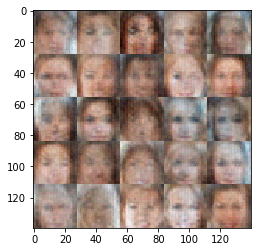

Epoch 1/1... Discriminator Loss: 1.3231... Generator Loss: 0.7988
Epoch 1/1... Discriminator Loss: 1.3750... Generator Loss: 0.7941
Epoch 1/1... Discriminator Loss: 1.3594... Generator Loss: 0.8231
Epoch 1/1... Discriminator Loss: 1.4190... Generator Loss: 0.8114


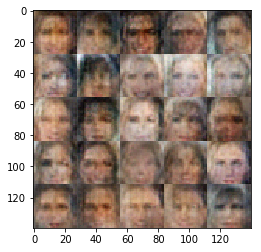

Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.7951
Epoch 1/1... Discriminator Loss: 1.3965... Generator Loss: 0.8422
Epoch 1/1... Discriminator Loss: 1.3782... Generator Loss: 0.7934
Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.8172


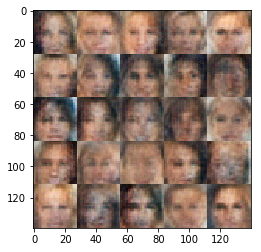

Epoch 1/1... Discriminator Loss: 1.3654... Generator Loss: 0.8015
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.4124... Generator Loss: 0.8517
Epoch 1/1... Discriminator Loss: 1.3976... Generator Loss: 0.7960


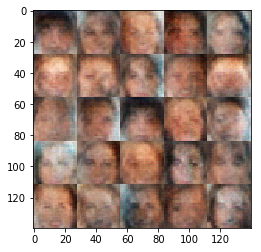

Epoch 1/1... Discriminator Loss: 1.4092... Generator Loss: 0.8050
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.8188
Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7801
Epoch 1/1... Discriminator Loss: 1.4505... Generator Loss: 0.7629


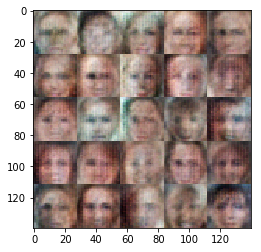

Epoch 1/1... Discriminator Loss: 1.2991... Generator Loss: 0.7761
Epoch 1/1... Discriminator Loss: 1.5206... Generator Loss: 0.8019
Epoch 1/1... Discriminator Loss: 1.3339... Generator Loss: 0.8157
Epoch 1/1... Discriminator Loss: 1.4384... Generator Loss: 0.7859


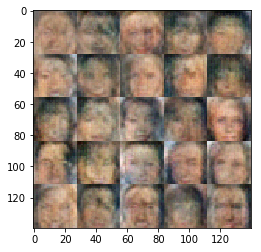

Epoch 1/1... Discriminator Loss: 1.3982... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.7893
Epoch 1/1... Discriminator Loss: 1.4589... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.4512... Generator Loss: 0.8396


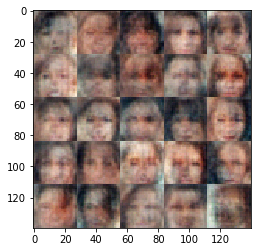

Epoch 1/1... Discriminator Loss: 1.3753... Generator Loss: 0.8245
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4115... Generator Loss: 0.7161


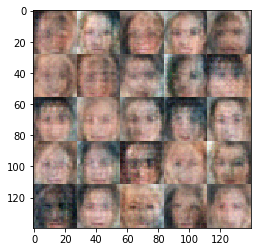

Epoch 1/1... Discriminator Loss: 1.3952... Generator Loss: 0.7293
Epoch 1/1... Discriminator Loss: 1.5638... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3726... Generator Loss: 0.7772
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.8038


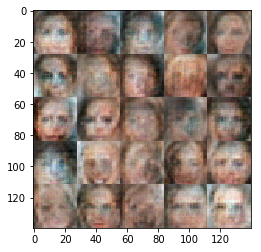

Epoch 1/1... Discriminator Loss: 1.3572... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3364... Generator Loss: 0.8020
Epoch 1/1... Discriminator Loss: 1.4025... Generator Loss: 0.7819
Epoch 1/1... Discriminator Loss: 1.3453... Generator Loss: 0.7732


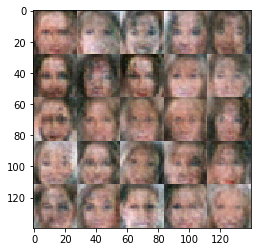

Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.8166
Epoch 1/1... Discriminator Loss: 1.3125... Generator Loss: 0.8391
Epoch 1/1... Discriminator Loss: 1.3670... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3507... Generator Loss: 0.7961


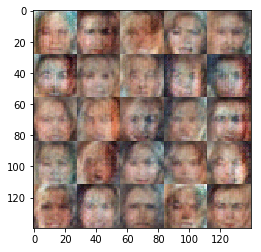

Epoch 1/1... Discriminator Loss: 1.4412... Generator Loss: 0.7812


In [18]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.